# <center><strong> Breast Cancer Classification with PYTORCH <strong><center>

This notebook describes how I used <strong>Pytorch</strong> to develop and train a neural network for breast cancer classification using tabular data. Deep learning is often associated with large datasets and image recognition/classification, so it was an interesting challenge to develop a network for tabular data. The dataset used in this problem can be found at <a href='https://github.com/smose94/Breast-Cancer-Detection'> breast-cancer.xls </a>.
    
    
<div class="alert alert-success"><strong>Note: This neural network was implemented using Pytorch v1.1.0.  </strong></div>
    
    

## Import the required libraries
As mentioned, the neural network is built using the Pytorch library. I also need to import Numpy, Pandas and scikit-learn for pre-processing of the data, and seaborn for visualisation.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import datetime
import seaborn as sns

## Import the dataset
Import the dataset using pandas. The first step is to conduct some Exploratory Data Analysis and look at any issues with the data e.g. anomalies, NaNs or missing values.

In [2]:
url = 'https://github.com/smose94/Breast-Cancer-Detection/blob/master/breast-cancer.xls?raw=True'
dataset = pd.read_excel(url)
dataset.head(6)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,2019-05-03 00:00:00,yes,2,left,right_up,no,recurrence-events
5,50-59,premeno,25-29,2019-05-03 00:00:00,no,2,right,left_up,yes,no-recurrence-events


We can also use <tt>.info()</tt> to look at the datatypes within each column of the dataset.

In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
age            286 non-null object
menopause      286 non-null object
tumor-size     286 non-null object
inv-nodes      286 non-null object
node-caps      286 non-null object
deg-malig      286 non-null int64
breast         286 non-null object
breast-quad    286 non-null object
irradiat       286 non-null object
Class          286 non-null object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB
None


In [4]:
# Search for errors in the raw dataset using value_counts() on each column
for col in dataset.columns:
    print(dataset[col].value_counts())

50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: age, dtype: int64
premeno    150
ge40       129
lt40         7
Name: menopause, dtype: int64
30-34                  60
25-29                  54
20-24                  50
15-19                  30
2014-10-01 00:00:00    28
40-44                  22
35-39                  19
0-4                     8
50-54                   8
2019-09-05 00:00:00     4
45-49                   3
Name: tumor-size, dtype: int64
0-2                    213
2019-05-03 00:00:00     36
2019-08-06 00:00:00     17
2019-11-09 00:00:00     10
15-17                    6
2014-12-01 00:00:00      3
24-26                    1
Name: inv-nodes, dtype: int64
no     222
yes     56
?        8
Name: node-caps, dtype: int64
2    130
3     85
1     71
Name: deg-malig, dtype: int64
left     152
right    134
Name: breast, dtype: int64
left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast-quad,

## Fixing Errors
From the output above, we can that the raw dataset has several errors. The first errors can be found within the <tt> 'inv-nodes' </tt> column, where 8 of the values are <tt> '?' </tt> We also see that the <tt> 'menopause' </tt> and <tt> 'tumor-size' </tt> columns have date values in place of the string values expected. I make the decision to drop the <tt> '?'s </tt> from the dataset.

In [5]:
dataset = dataset.replace("?", np.nan).dropna()

I interpret that the date values in the tumor-size column refer to the ranges 5-9 and 10-14. I also assume the inv-nodes column dates refer to 3-5, 6-8, 9-11, 12-14. First I separate rows with datetime objects from the raw dataset. Then, I replace the datetime object with a string that depends on the year of the datetime object.

#### <div class="alert alert-danger"><strong>Note: </strong>The code below seems a convoluted way to replace the erroneous datetime values with the actual strings required. I also looked at alternative means such as <strong><tt>np.where</tt></strong> but couldn't seem to find a method that worked as I needed. In the end, I settled for what's below but would be very happy to see a smarter/neater solution.</div>

In [6]:
mask = dataset['tumor-size'].apply(lambda x: isinstance(x, datetime.datetime))
dataset_dates = dataset[mask].reset_index(drop=True)
dataset_remain = dataset[~mask].reset_index(drop=True)

for i in range(len(dataset_dates)):
    if dataset_dates.loc[i, 'tumor-size'].strftime('%Y') == '2014':
        dataset_dates.loc[i,'tumor-size'] = '10-14'
    else:
        dataset_dates.loc[i,'tumor-size'] = '5-9'

#Append the amended dataframe back to old one and then repeat this process again for the inv-nodes columns
dataset = dataset_remain.append(dataset_dates).reset_index(drop=True)


Do the same for the <tt>inv-nodes</tt> column.



In [7]:
# [0-2],[3-5],[6-8],[9-11].[12-14],[15-17],[24-26] outlier??
mask = dataset['inv-nodes'].apply(lambda x: isinstance(x, datetime.datetime))
dataset_dates = dataset[mask].reset_index(drop = True)
dataset_remain = dataset[~mask].reset_index(drop=True)

for i in range(len(dataset_dates)):
    dataset_dates.loc[i, 'inv-nodes'] = dataset_dates.loc[i,'inv-nodes'].strftime('%m')
    
    if dataset_dates.loc[i,'inv-nodes'] == '05':
        dataset_dates.loc[i,'inv-nodes'] = '3-5'
    elif dataset_dates.loc[i,'inv-nodes'] == '08':
        dataset_dates.loc[i,'inv-nodes'] = '6-8'
    elif dataset_dates.loc[i,'inv-nodes'] == '11':
        dataset_dates.loc[i,'inv-nodes'] = '9-11'
    elif dataset_dates.loc[i,'inv-nodes'] == '12':
        dataset_dates.loc[i,'inv-nodes'] = '12-14'
    else:
        pass
    
dataset = dataset_remain.append(dataset_dates).reset_index(drop=True)

Next, I shuffle the dataset using scikit-learn's <tt><strong>shuffle</strong></tt> feature. This is to ensure that the data isn't indexed in a sorted order that could impact the model's ability to discern each data point's individual impact. 

In [8]:
dataset = shuffle(dataset, random_state = 101)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,60-69,ge40,50-54,0-2,no,2,right,left_up,yes,no-recurrence-events
1,40-49,premeno,30-34,15-17,yes,3,left,left_low,no,recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,left_up,no,no-recurrence-events
3,50-59,premeno,25-29,3-5,no,2,right,left_up,yes,no-recurrence-events
4,40-49,premeno,30-34,0-2,no,1,left,left_low,no,no-recurrence-events


I want a quick overview of the effects of <tt>age</tt>, <tt>menopause</tt>, <tt>breast</tt> and <tt>breast-quad</tt> on the recurrence rates. I use seaborn's countplot to generate 4 subplots and see if there's any obvious insights to gain.

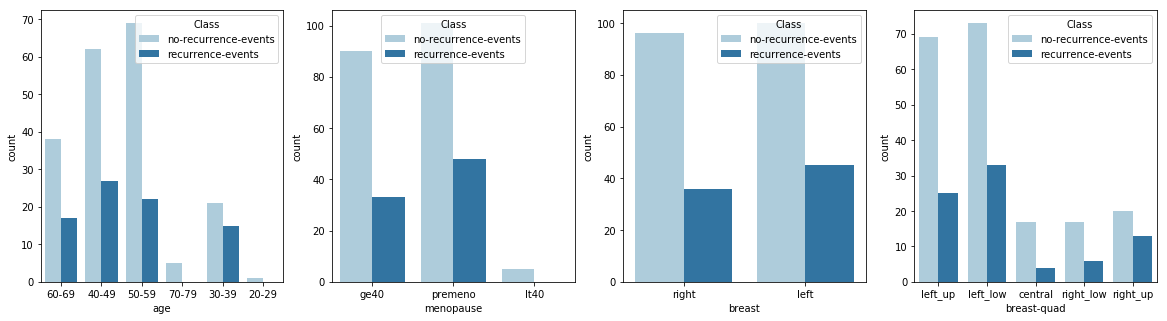

In [9]:
cols = ['age','menopause','breast','breast-quad']
fig, axes = plt.subplots(ncols=4,figsize=(20,5))
current = 0
for col in cols:
    sns.countplot(x=f'{col}', data=dataset,hue='Class',palette='Paired',ax=axes[current])
    current += 1

Formal statisitical tests could be performed at this point to expand on the quick-look above and determine the level at which each of the categories has an effect on the recurrence rates. The similarity in the counts for <tt>left breast</tt> vs <tt>right breast</tt> is a point to note, and I actually find that the model's accuracy is increased when removing the <tt>breast</tt> column from the dataset.

## Setup data for Pytorch
The neural network will be implemented using a tabular model. The model will take in 3 types of data: categorical data, continuous data, and the label class (e.g. recurrence-events vs. no-recurrence-events). The next step is therefore to break the dataset out into these three types.

For the continuous columns, I apply feature scaling to normalise the values and improve the model's time to convergence. In datasets with more continuous columns, feature scaling also has the value in reducing the chance the neural network applies higher weights to variables of higher magnitudes, therefore biasing the network. 

Each of the datatypes will then need to be transformed into a <tt>Torch.Tensor</tt> for ready-use with <tt>Pytorch</tt>.

In [10]:
#Set up the categorical, continuous and y columns for Pytorch
cat_cols = ['age','menopause','tumor-size','inv-nodes','node-caps','breast-quad','irradiat']
cont_cols = ['deg-malig']
y = dataset.pop('Class')

for col in cat_cols:
    dataset[col] = dataset[col].astype('category')
for col in cont_cols:
    dataset[col] = dataset[col].astype('float64')

#Change to category type of columns then set as Torch Tensor
cats = np.stack([dataset[col].cat.codes.values for col in cat_cols],1)
cats = torch.tensor(cats,dtype=torch.int64)


#Set up continuous variable columns as a Torch Tensor
conts = np.stack([dataset[col].values for col in cont_cols],axis=1)
#Need to feature scale the continuous variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()    
conts = sc.fit_transform(conts)
# Set up the cont tensor
conts = torch.tensor(conts,dtype=torch.float)

# Convert label column (class) into tensor
# First need to map the string values of reccurence/no-recurrence to 0 or 1
y = y.map({'no-recurrence-events':0,'recurrence-events':1})
y = torch.tensor(y.values, dtype=torch.long).flatten()

## Setup the Embeddings
Currently, we have several categorical columns, each of which contains multiple categories. If we loop through each of the categories and return the number of unique values within, we get the result below. 

In [11]:
for col in cat_cols:
    print(f'{col.upper()} has {len(dataset[col].value_counts())} unique values')

AGE has 6 unique values
MENOPAUSE has 3 unique values
TUMOR-SIZE has 11 unique values
INV-NODES has 7 unique values
NODE-CAPS has 2 unique values
BREAST-QUAD has 5 unique values
IRRADIAT has 2 unique values


We need a way to feed these string values into the model as a number: this is where embedding comes in. Effectively, embedding performs a similar function to scikit-learn's OneHotEncoder in that it assigns a vector of numbers to each of the unique values within each category, all held within a lookup table. E.g. the value <tt>40-49</tt> within the <tt>age</tt> column could be represented as [0.13, 0.33, 0.64, 0.52]. We need to apply this to each of the categories. 

In [12]:
#Set up embedding values - this is similar to OneHotEncoding categorical values in SKLearn
cat_sizes = [len(dataset[col].cat.categories) for col in cat_cols]
emb_sizes = [(size,min(50,(size+1)//2)) for size in cat_sizes]
print(emb_sizes)

[(6, 3), (3, 2), (11, 6), (7, 4), (2, 1), (5, 3), (2, 1)]


## Defining the Tabular Model
The goal is to define a model based on the number of continuous columns (given by conts.shape[1]) plus the number of categorical columns and their embeddings (given by len(emb_szs) and emb_szs respectively). The output would either be a regression (a single float value), or a classification. For this exercise the output will be a classification. The model is built upon Pytorch's <tt>Module</tt> class.

The inputs to the model are listed below:
   * <tt>emb_sizes: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_size:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer

In [13]:
class TabularModel(nn.Module):
# Model takes in the embedding sizes initiliased above, number of continuous variables,
# output layer size (e.g for classification this =2, and dropout probability e.g 0.5 = 50%)
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        #This call allows us to utilise the nn.Module class already built, extending our own definitions onto it
        super().__init__()
        #Set up the embeddings
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        #Initialise a dropout function (equal to p) During training, this randomly zeros p% of the input tensor
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

I set up a sequence of neural network layers, where each includes:

* A Linear function, 
* An Activation function 
    * <small>for the baseline model I use ReLU, but I'll show use of Softmax as well</small>
* A Normalization step
    * <small> this is applied to the continuous variable(s)
* A Dropout layer
    
I combine the list of layers using <tt>torch.nn.Sequential()</tt>

# Model Instance
Next, I need to create an instance of the model, and define the loss criteria as well as the optimiser for the forward pass. The model takes in five inputs, as described above. For my first iteration, I initialise the following parameters:

* emb_sizes = emb_sizes
* n_cont = conts.shape[1]
    * In this model, the number of continuous inputs is 1 (deg-malig column)
* out_size = 2
    * <small>The output size is equal to the number of outputs your model produces. E.g a regression model would be outputting 1 value if you were attempting to predict a house price based on its location, size, number of rooms etc. 
    * In this case we have a simple classification problem, in which each prediction can take one of two values: <strong>recurrence</strong> or <strong>no recurrence</strong>. Therefore, the number of outputs is equal to two. For each predicition, the model will output a tuple e.g [0.88888, -0.12339], where the maximum value's index (0 or 1) determines the predicition. In this example, the maximum value (0.88888) is found at index 0, which therefore corresponds to <strong> no recurrence</strong>.
* layers = [10,20]
    * <small> The first value corresponds to the number of out features in the first Linear layer, the second value effectively initialises a second forward pass with the number of out features in the Linear layer equal to it. The vlaues of 10 and 20 were chosen arbitrarily.
* p = 0.2 (20% dropout)



For the baseline model optimiser, I have chosen to use the Adaptive Moment Estimate (ADAM). I use CrossEntropyLoss as the loss criterion due to it being a classfication problem. In regression models, an RMSE loss criterion is typically applied instead. Finally, I use an initial learning rate of 0.001. The choice of 0.001 is 50% arbitrary and 50% guided by standard practise. A lower learning rate will increase the model's time to convergence, and a higher learning rate may cause the model to miss the point of minimum loss.

In [14]:
#Create model instance
model = TabularModel(emb_sizes,conts.shape[1],2, [10,15],p=0.2)
 
#Set the cost function and fit optimisier (using ADAM)
criterion = nn.CrossEntropyLoss() #np.sqrt(MSE) --> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(3, 2)
    (2): Embedding(11, 6)
    (3): Embedding(7, 4)
    (4): Embedding(2, 1)
    (5): Embedding(5, 3)
    (6): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.2)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=10, out_features=15, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2)
    (8): Linear(in_features=15, out_features=2, bias=True)
  )
)


## Splitting out the dataset
The model is almost ready to train. For each of the 3 data sources (categorical, continuous and label) I need to break them out into a test set and a train set. As is standard practice, I use a 80:20 test:train split. However, given the size of the dataset, the model performance is highly variable to this ratio (as will be shown later on).

In [15]:
#Split out into a test and train set of approx 20:80 ratio
cat_train = cats[55:]
cat_test = cats[:55]
con_train = conts[55:]
con_test = conts[:55]

y_train = y[55:]
y_test = y[:55]

## Running the neural network
Finally, we are able to train the network and allow it to make its predictions. I initially set the network to train for 2500 epochs.

In [16]:
# Set seed of Pytorch = to random int in order to ensure model's parameters are constant
# This will enable me to tune model and hyperparameters and measure changes in accuracy solely based on my changes
torch.manual_seed(33)

import time

start_time = time.time()
epochs = 2500

losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train,con_train)
    loss = criterion(y_pred,y_train)
    losses.append(loss)
    
    if i%100 ==1:
        print(f'Epoch: {i} loss is {loss:.4f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


duration = time.time() - start_time
print(f'Training took {duration/60:.2f} minutes')
    

with torch.no_grad():
    y_val = model(cat_test,con_test)
    loss = criterion(y_val, y_test)

#y_pred = pd.DataFrame(np.argmax(y_val.numpy(),axis=1))
correct = 0
for i in range(len(y_test)):
    if y_val[i].argmax().item() == y_test[i]:
        correct +=1
print(f'Accuracy: {100*correct/len(y_test):.2f}%')


Epoch: 1 loss is 0.6891
Epoch: 101 loss is 0.5436
Epoch: 201 loss is 0.4955
Epoch: 301 loss is 0.4654
Epoch: 401 loss is 0.4592
Epoch: 501 loss is 0.3992
Epoch: 601 loss is 0.3602
Epoch: 701 loss is 0.3900
Epoch: 801 loss is 0.4025
Epoch: 901 loss is 0.4056
Epoch: 1001 loss is 0.3841
Epoch: 1101 loss is 0.3419
Epoch: 1201 loss is 0.3721
Epoch: 1301 loss is 0.3660
Epoch: 1401 loss is 0.3197
Epoch: 1501 loss is 0.3497
Epoch: 1601 loss is 0.3258
Epoch: 1701 loss is 0.3518
Epoch: 1801 loss is 0.3398
Epoch: 1901 loss is 0.3090
Epoch: 2001 loss is 0.3300
Epoch: 2101 loss is 0.3195
Epoch: 2201 loss is 0.2981
Epoch: 2301 loss is 0.3609
Epoch: 2401 loss is 0.3323
Training took 0.55 minutes
Accuracy: 80.00%


Text(0, 0.5, 'CrossEntropyLoss')

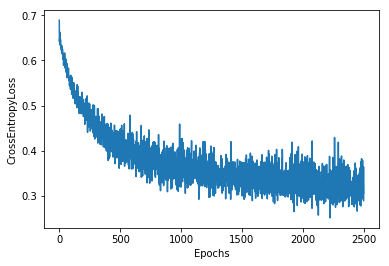

In [17]:
%matplotlib inline
plt.plot(range(epochs),losses)
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')

In [192]:
# Saving the model 
if len(losses) == epochs:
    torch.save(model.state_dict(), 'Breast_Cancer_V1.0.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Performance
From the result above, we can see that the neural network obtains an accuracy of 74.55%. For a first attempt at a neural network, this is a reasonable accuracy. But, whilst I have yet to apply a more simple machine learning algorithm (such as random forest) to this dataset, a 75% accuracy represents a middle-of-the-road score and there's scope for improvement. An 80% accuracy threshold is an ideal target to aim for. I vary parameters such as the learning rate, the activation function (ReLU vs Softmax), and the number of layers.

One interesting observation is, upon increasing the number of epochs to train on, I reduced my model's loss (as expected) but also reduced my model's accuracy. This is actually not uncommon behaviour (especially in small datasets) and is down to <strong> high variance </strong>. Increasing the number of data points from which I can train the model would help reduce this issue. 

## Submission
I manage to achieve an accuracy of % with the neural network as shown in my <a href='https://github.com/smose94/Breast-Cancer-Detection/blob/master/submission_01'> final submission </a>. The submission supplied was tested and successfully ran in Google's Colab on <strong><tt>04/05/2020</tt></strong>. 

This project has been a great introduction to neural networks, and I will continue to investigate not only the effects of changing certain parameters but gain a greater understanding of the maths behind it, too. In terms of next steps, I want to apply the <tt> grid search</tt> method to my network above and see if I can use it to find the optimal hyperparameter values for my dataset. 